In [2]:
#| code-fold: true
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import SimpleITK as sitk
from diffdrr.data import load_example_ct
from diffdrr.drr import DRR, Registration
from diffdrr.metrics import NormalizedCrossCorrelation2d
from diffdrr.visualization import plot_drr
import os
np.random.seed(39)

In [3]:
# define path and load the data (both CT and X-ray)
data_path = r'C:\Users\p70089067\Data\KNO_data_dir\SlicerData(Ben)\CVI11_Joost'
CT_path = os.path.join(data_path,   'preop.nrrd') # 'intra_CT_1.nii.gz')
assert os.path.exists(CT_path)
CT_data = sitk.ReadImage(CT_path)
CT_np = sitk.GetArrayFromImage(CT_data)
CT_spacing = list(CT_data.GetSpacing())

Xray1_path = os.path.join(data_path,'Fluoro_1.nii.gz')
Xray2_path = os.path.join(data_path,'Fluoro_2.nii.gz')
Xray3_path = os.path.join(data_path,'Fluoro_3.nii.gz')
assert os.path.exists(Xray1_path) and os.path.exists(Xray2_path) and os.path.exists(Xray3_path)
Xray1_data = sitk.ReadImage(Xray1_path)
Xray2_data = sitk.ReadImage(Xray2_path)
Xray3_data = sitk.ReadImage(Xray3_path)
Xray1_np = sitk.GetArrayFromImage(Xray1_data)
Xray2_np = sitk.GetArrayFromImage(Xray2_data)
Xray3_np = sitk.GetArrayFromImage(Xray3_data)

# print data info
print('CT:')
print('shape of CT:', CT_np.shape)
print('spacing of CT', CT_spacing)
print('X-ray:')
print('shape of X-ray:', Xray1_np.shape)
print('spacing of X-ray', Xray1_data.GetSpacing())


CT:
shape of CT: (198, 512, 512)
spacing of CT [0.390625, 0.390625, 0.30000000000000077]
X-ray:
shape of X-ray: (1, 976, 976)
spacing of X-ray (0.15199999511241913, 0.15199999511241913, 1.0)


In [ ]:
# visualization of intra op CT
import matplotlib.pyplot as plt
plt.figure('CT intra op', figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(CT_np[190, :, :], cmap='gray')
plt.subplot(2,2,2)
plt.imshow(CT_np[200, :, :], cmap='gray')
plt.subplot(2,2,3)
plt.imshow(CT_np[210, :, :], cmap='gray')
plt.subplot(2,2,4)
plt.imshow(CT_np[220, :, :], cmap='gray')

Text(0.5, 1.0, 'X-ray 3')

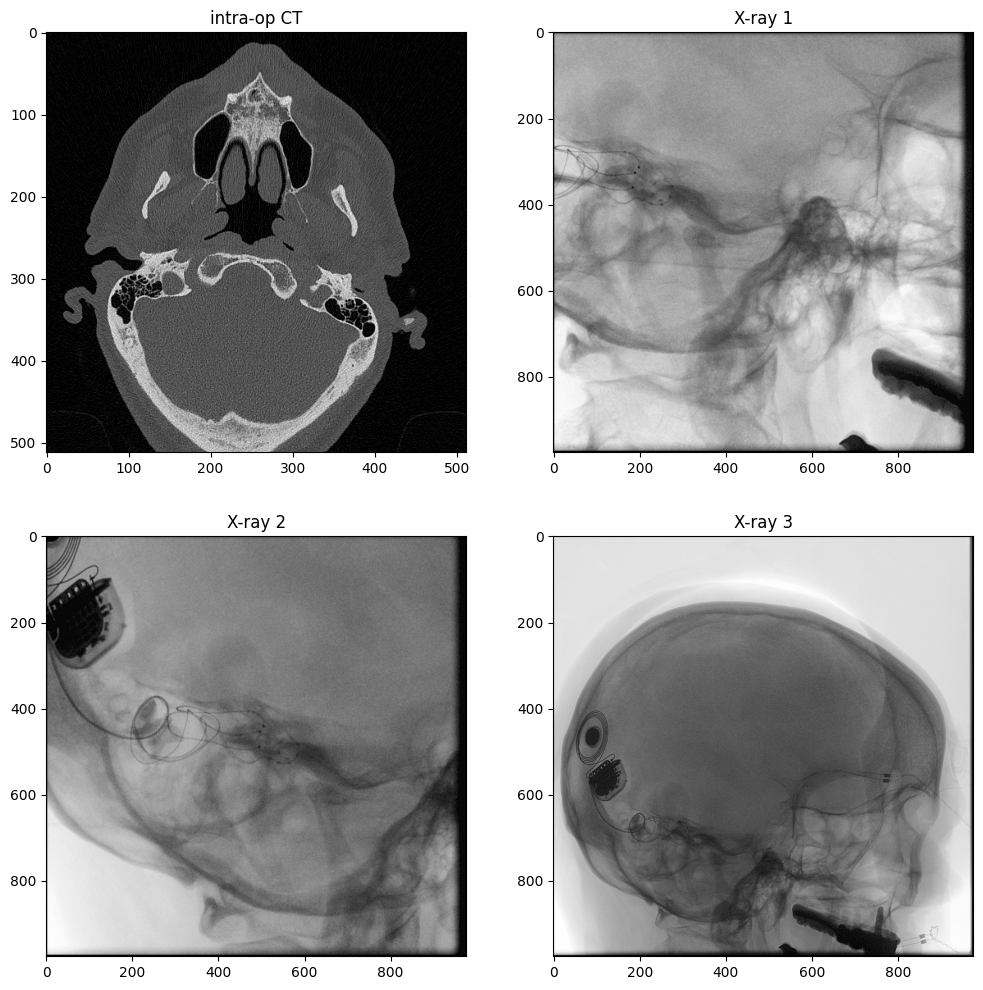

In [4]:
# visualization of CT and X-ray
import matplotlib.pyplot as plt
plt.figure('CT and X-ray', figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(CT_np[100, :, :], cmap='gray')
plt.title('intra-op CT')
plt.subplot(2,2,2)
plt.imshow(Xray1_np[0], cmap='gray')
plt.title('X-ray 1')
plt.subplot(2,2,3)
plt.imshow(Xray2_np[0], cmap='gray')
plt.title('X-ray 2')
plt.subplot(2,2,4)
plt.imshow(Xray3_np[0], cmap='gray')
plt.title('X-ray 3')


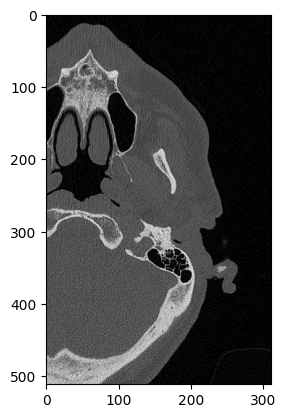

In [5]:
CT_half = CT_np[:,:, 200:]
plt.imshow(CT_half[100, :, :], cmap='gray')

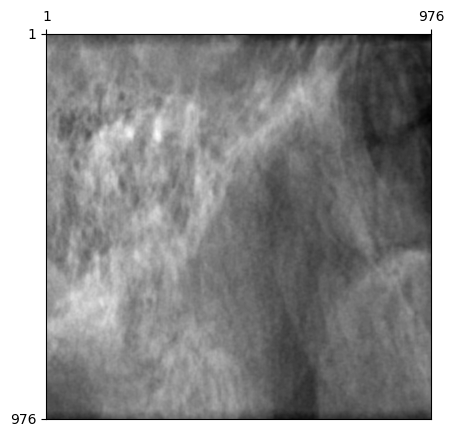

In [14]:
# Make drr based on CT
SDR = 400.0
HEIGHT = 976
DELX = 0.15199999511241913


bx, by, bz = np.array(CT_np.shape) * np.array(CT_spacing) / 2 # center location
true_params = {
    "sdr": SDR,
    "alpha": 0,
    "beta": torch.pi/2,
    "gamma": torch.pi/2,
    "bx": bx,
    "by": by,
    "bz": bz,
}
device = "cuda" if torch.cuda.is_available() else "cpu"

drr = DRR(CT_np.astype(np.float32), CT_spacing, sdr=SDR, height=HEIGHT, delx=DELX, bone_attenuation_multiplier=0.8,renderer="trilinear").to(device)
rotations = torch.tensor(
    [
        [
            true_params["alpha"],
            true_params["beta"],
            true_params["gamma"],
        ]
    ]
).to(device)
translations = torch.tensor(
    [
        [
            true_params["bx"],
            true_params["by"],
            true_params["bz"],
        ]
    ]
).to(device)
CT_drr = drr(
    rotations,
    translations,
    parameterization="euler_angles",
    convention="ZYX",
    n_points = 200
)

plot_drr(CT_drr)
plt.show()


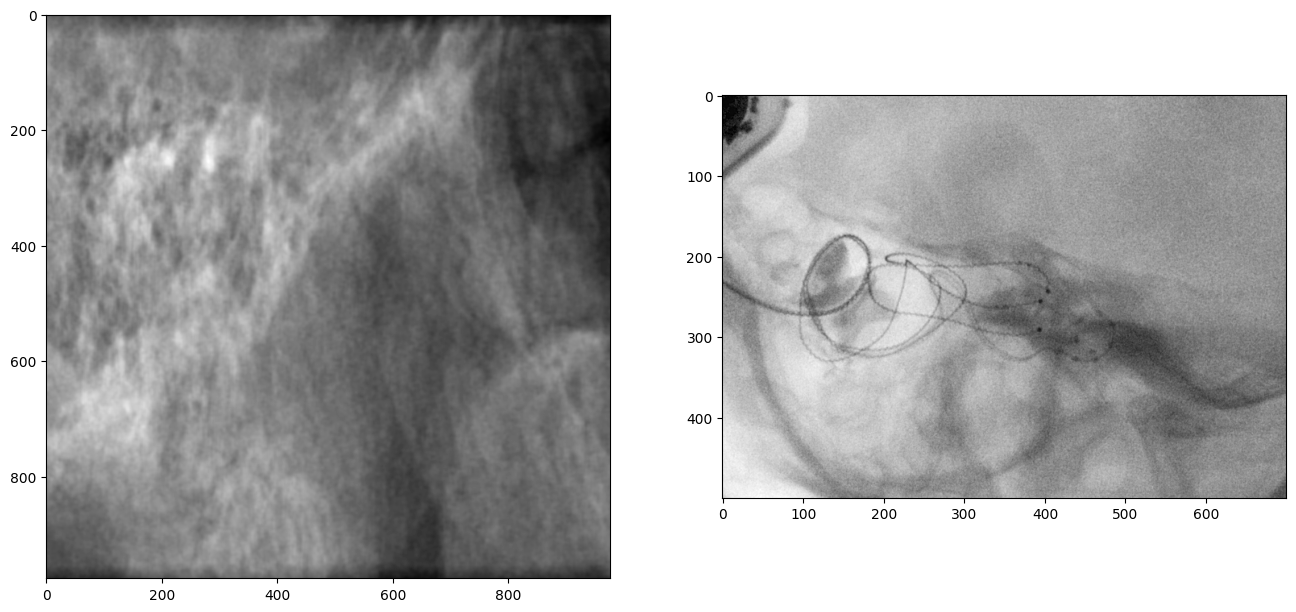

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(CT_drr.detach().cpu().squeeze().numpy(), cmap='grey')
plt.subplot(1,2,2)
plt.imshow(Xray2_np[0, 200:700, 100:800],  cmap='grey')

In [12]:
CT_drr.shape

torch.Size([1, 1, 976, 976])

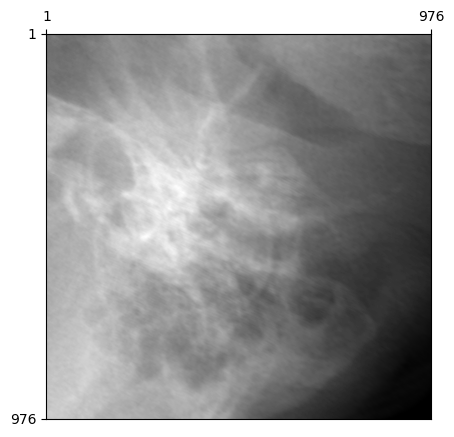

In [18]:
#| code-fold: true
# Make a random DRR
def get_initial_parameters(true_params):
    alpha = true_params["alpha"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    beta = true_params["beta"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    gamma = true_params["gamma"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    bx = true_params["bx"] + np.random.uniform(-30.0, 31.0)
    by = true_params["by"] + np.random.uniform(-30.0, 31.0)
    bz = true_params["bz"] + np.random.uniform(-30.0, 31.0)
    rotation = torch.tensor([[alpha, beta, gamma]]).to(device)
    translation = torch.tensor([[bx, by, bz]]).to(device)
    return rotation, translation


rotations, translations = get_initial_parameters(true_params)
drr = DRR(CT_np.astype(np.float32), CT_spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
with torch.no_grad():
    est = drr(
        rotations,
        translations,
        parameterization="euler_angles",
        convention="ZYX",
    )
plot_drr(est)
plt.show()

In [33]:
Xray1_np.astype(np.float32)

array([[[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0., 1464., ...,    6.,    0.,    0.],
        ...,
        [   0.,    0.,  107., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]]], dtype=float32)

In [37]:
xray = np.expand_dims(Xray1_np.astype(np.float32), 0)

In [44]:
ground_truth = torch.tensor(xray).to(device)

In [45]:
criterion = NormalizedCrossCorrelation2d()
criterion(ground_truth ,est).item()

0.0018226634711027145

In [43]:
def optimize(
    reg: Registration,
    ground_truth,
    lr_rotations=5.3e-2,
    lr_translations=7.5e1,
    momentum=0,
    dampening=0,
    n_itrs=250,
    optimizer="sgd",  # 'sgd' or `adam`
):
    criterion = NormalizedCrossCorrelation2d()
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(
            [
                {"params": [reg.rotation], "lr": lr_rotations},
                {"params": [reg.translation], "lr": lr_translations},
            ],
            momentum=momentum,
            dampening=dampening,
            maximize=True,
        )
    else:
        optimizer = torch.optim.Adam(
            [
                {"params": [reg.rotation], "lr": lr_rotations},
                {"params": [reg.translation], "lr": lr_translations},
            ],
            maximize=True,
        )

    params = []
    losses = []
    for itr in tqdm(range(n_itrs), ncols=50):
        # Save the current set of parameters
        alpha, beta, gamma = reg.get_rotation().squeeze().tolist()
        bx, by, bz = reg.get_translation().squeeze().tolist()
        params.append([i for i in [alpha, beta, gamma, bx, by, bz]])

        # Run the optimization loop
        optimizer.zero_grad()
        estimate = reg()
        loss = criterion(ground_truth, estimate)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.item())

        if loss > 0.999:
            tqdm.write(f"Converged in {itr} iterations")
            break

    df = pd.DataFrame(params, columns=["alpha", "beta", "gamma", "bx", "by", "bz"])
    df["loss"] = losses
    return df

In [51]:
volume = CT_np.astype(np.float32)
drr = DRR(volume, CT_spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
reg = Registration(
    drr,
    rotations.clone(),
    translations.clone(),
    parameterization="euler_angles",
    convention="ZYX",
)

In [52]:
params_base = optimize(reg, ground_truth)

  0%|                     | 0/250 [00:00<?, ?it/s]

In [14]:
params_base

,alpha,beta,gamma,bx,by,bz,loss
0,3.215246,0.623918,2.241844,157.445042,186.722122,168.306390,0.503051
1,3.218231,0.621462,2.230732,157.703904,186.725018,168.078886,0.507421
2,3.218675,0.620134,2.224564,157.961572,186.649461,167.879987,0.510453
3,3.219899,0.619170,2.208573,158.216591,186.635623,167.678790,0.516247
4,3.222367,0.618365,2.194869,158.465582,186.644038,167.474419,0.521498
...,...,...,...,...,...,...,...
134,3.144144,0.002416,1.570675,177.648237,179.965193,166.248365,0.998764
135,3.144127,0.002342,1.570183,177.720592,179.969613,166.255067,0.998835
136,3.143978,0.002235,1.570566,177.790803,179.971590,166.263578,0.998902
137,3.143863,0.002134,1.570139,177.859921,179.975629,166.268545,0.998965
